# Graph Colouring 

### Definition

We are given an undirected graph with vertex set $V$ and edge set $E$ and a set of $n$ colours.

Our aim is to find whether we can colour every node of the graph in one of these $n$ colours such that no edge connects nodes of the same colour.

### Applications
Graph Colouring appears in a variety of real life problems like map colouring, scheduling, register allocation, frequency assignment, communication networks and timetables.

### Path to solving the problem
Graph Colouring can be formulated as a minimization problem and its cost function can be cast to a QUBO problem with its respective Hamiltonian (see the [Introduction](./introduction_combinatorial_optimization.ipynb) and a [reference](https://arxiv.org/abs/1302.5843)),
$$ \displaystyle \large
H = \textstyle\sum\limits_{v}\displaystyle \left( 1 -\textstyle\sum\limits_{i=1}^{n} x_{v,i} \right) ^2 + \textstyle\sum\limits_{uv \in E} \textstyle\sum\limits_{i=1}^{n} x_{u,i} x_{v,i}
$$

where $v, u \in V$ and $x_{v,i}$ is a binary variable, which is $1$ if vertex $v$ has colour $i$ and $0$ otherwise.

The QLM allows us to encode a problem in this Hamiltonian form by using the `GraphColouring` class for a given graph and a number of colours. We can then create a job from the problem and send it to a heuristic Simulated Quantum Annealer (SQA)  wrapped inside a Quantum Processing Unit (QPU) like the rest of the QPUs on the QLM. The SQA will minimize the $H$, hence we find the best solution to our problem.

For a more detailed explanation and a step-by-step guidance, please follow the sections below.

### Quantum resources
To represent the problem as QUBO the QLM would need $nN$ spins, where $N$ is the number of vertices of the graph. The classical complexity of the [best known approximation algorithm](https://www.sciencedirect.com/science/article/abs/pii/0020019093902466?via%3Dihub) for this problem is $O(N(log log N)^2(log N)^3)$ 

# Example problem

Imagine we are given $3$ colours and a graph with $4$ vertices and $5$ edges, as shown below (left). This problem has a simple solution $-$ nodes $0$ and $3$ will share one colour and the other two colours are assigned to nodes $1$ and $2$ (right). 

<br><img src="./graph_colouring_example_solution2.png" style="width: 850px"><br>

Let us describe how one can reach this answer using tools from the QLM. 
However, the approach will be applicable to finding the Graph Colouring of whatever graph we are given !

We will use the `networkx` library to specify our graph (or in fact any graph, as the library is quite rich). 

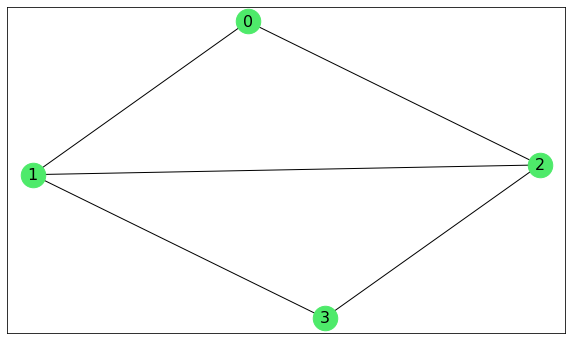

In [1]:
import networkx as nx
import numpy as np
import matplotlib.pyplot as plt

# Specify the graph 
# First example
graph = nx.Graph()
graph.add_nodes_from(np.arange(4))
graph.add_edges_from([(0, 1), (0, 2), (1, 2), (1, 3), (2, 3)])

# # Second example - one can try with 4 or 5 colours
# graph = nx.gnm_random_graph(15, 40)

# Specify the number of colours
number_of_colours = 3
number_of_nodes = len(graph.nodes())
number_of_spins = number_of_colours * number_of_nodes

# Draw the graph
nodes_positions = nx.spring_layout(graph, iterations=number_of_nodes * 60)
plt.figure(figsize=(10, 6))
nx.draw_networkx(graph, 
                 pos=nodes_positions, 
                 node_color='#4EEA6A', 
                 node_size=600, 
                 font_size=16)
plt.show()

To encode the problem in a QUBO form, as described above, we will call the `GraphColouring` class.

In [2]:
from qat.opt import GraphColouring

graph_colouring_problem = GraphColouring(graph, number_of_colours)

# Solution

Once an instance of the problem is created, we can proceed to compute the solution of the problem by following the steps:

1. Extract the best SQA parameters found for Graph Colouring by calling the method `get_best_parameters()`.

    The number of Monte Carlo updates is the total number of updates performed for each temperature (and gamma) on the spins of the equivalent 2D classical system. These updates are the product of the number of annealing steps $-$ `n_steps`, the number of "Trotter replicas" $-$ `n_trotters`, and the problem size, i.e. the number of qubits needed. Hence, we can use these parameters to get the best inferred value for `n_steps`. In general, the more these steps are, the finer and better the annealing will be. However this will cause the process to take longer to complete.
    
    Similarly for the `n_trotters` field in `SQAQPU` $-$ the higher it is, the better the final solution could be, but the more time taken by the annealer to reach an answer.


2. Create a temperature and a gamma schedule for the annealing.

    We use the extracted max and min temperatures and gammas to create a (linear) temperature and a (linear) gamma schedule. These schedules evolve in time from higher to lower values since we simulate the reduction of temperatures and magnetic fields. If one wishes to vary them it may help if the min values are close to $0$, as this will cause the Hamiltonian to reach a lower energy state, potentially closer to its ground state (where the solution is encoded).

    It should be noted that non-linear schedules may be investigated too, but for the same number of steps they could lead to a slower annealing. The best min and max values for gamma and the temperature were found for linear schedules.


3. Generate the SQAQPU and create a job for the problem. The job is then sent to the QPU and the annealing is performed.


4. Present the solution spin configuration. 


5. Show a dictionary of vertices for each colour.


6. Draw the coloured graph.

When we look at the final spin configuration, we see spins on each row and column. The rows represent the vertices, i.e. the second row (counting from $0$) is for the second vertex (again counting from $0$). The spins of each row are then the binary representation of the colour of that vertex, but with spin values, i.e. $\{1, -1\}$ instead of $\{1, 0\}$.

So if a spin at position $(2,1)$ is $1$, this means that the second vertex has the first colour (again counting from $0$).

Solution configuration: 
[[-1.  1. -1.]
 [ 1. -1. -1.]
 [-1. -1.  1.]
 [-1.  1. -1.]]

Dictionary of vertices for each colour:
{0: [1], 1: [0, 3], 2: [2]}



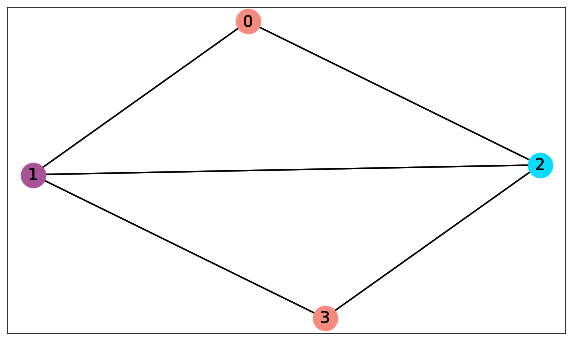

In [3]:
from qat.core import Variable
from qat.sqa import SQAQPU
from qat.sqa.sqa_qpu import integer_to_spins

# 1. Extract parameters for SQA
problem_parameters_dict = graph_colouring_problem.get_best_parameters()
n_monte_carlo_updates = problem_parameters_dict["n_monte_carlo_updates"]
n_trotters = problem_parameters_dict["n_trotters"]
n_steps = int(n_monte_carlo_updates /
              (n_trotters * number_of_spins)) # the last one is the number of spins, i.e. the problem size
temp_max = problem_parameters_dict["temp_max"]
temp_min = problem_parameters_dict["temp_min"]
gamma_max = problem_parameters_dict["gamma_max"]
gamma_min = problem_parameters_dict["gamma_min"]

# 2. Create a temperature and a gamma schedule
tmax = 1.0
t = Variable("t", float)
temp_t = temp_min * (t / tmax) + temp_max * (1 - t / tmax)
gamma_t = gamma_min * (t / tmax) + gamma_max * (1 - t / tmax)

# 3. Create a job and send it to a QPU
problem_job = graph_colouring_problem.to_job(gamma_t=gamma_t, tmax=tmax, nbshots=1)
sqa_qpu = SQAQPU(temp_t=temp_t, n_steps=n_steps, n_trotters=n_trotters)
problem_result = sqa_qpu.submit(problem_job)

# 4. Present best configuration
state_int = problem_result.raw_data[0].state.int  # raw_data is a list of Samples - one per shot
solution_configuration = integer_to_spins(state_int, number_of_spins)
solution_configuration_reshaped = solution_configuration.reshape((number_of_nodes, number_of_colours))
print("Solution configuration: \n" + str(solution_configuration_reshaped) + "\n")

# 5. Show a list of nodes for each colour
from itertools import product
vertices_dictionary = {colour:[] for colour in range(number_of_colours)}
for row, col in product(range(number_of_nodes), range(number_of_colours)):
    if solution_configuration[row * number_of_colours + col] == 1:
        vertices_dictionary[col].append(row)
print("Dictionary of vertices for each colour:\n" + str(vertices_dictionary) + "\n")

# 6. Draw the coloured graph
import random
colour_list = ['#'+''.join(random.sample('0123456789ABCDEF', 6)) for i in range(number_of_colours)]
plt.figure(figsize=(10, 6))
for node in graph.nodes(): 
    if graph.nodes[node]: del graph.nodes[node]['colour']
for i in range (number_of_colours):
    colour_i = colour_list[i]
    nodes_with_colour_i = vertices_dictionary[i]
    for node in nodes_with_colour_i: graph.nodes[node]['colour'] = i
    nx.draw_networkx(graph, 
                     pos=nodes_positions, 
                     nodelist=nodes_with_colour_i, 
                     node_color=colour_i, 
                     node_size=600, 
                     font_size=16)

nx.draw_networkx_edges(graph, pos=nodes_positions)
plt.show()

# Solution analysis

In order to examine the output colouring, one may choose to visually inspect the graphs. However, this becomes impractical for very big graphs with large dictionaries. We can therefore add some simple checks to assess the solution. 

One such check would be if each vertex has exactly one colour (which may not be the case, for example when the value $1$ appears more than once in a row of the solution spin array).

In [4]:
corrupted_nodes_list = []
corrupted_nodes_colours_dict = {}
for node in range(number_of_nodes):
    node_colourings_row = solution_configuration_reshaped[node][:]
    colours_array = np.argwhere(node_colourings_row == 1)
    number_of_colours_of_node = len(colours_array)
    if number_of_colours_of_node != 1:
        corrupted_nodes_list.append(node)
        corrupted_nodes_colours_dict[node] = colours_array.flatten().tolist()

if len(corrupted_nodes_list) == 0:
    print("Each vertex is assigned only one colour !")
else: 
    print("There are " + "\033[1m" + str(len(corrupted_nodes_list)) + 
          "\033[0;0m" + " vertices not assigned exactly one colour:\n" + 
          str(corrupted_nodes_list))
    print("\nVertices and their colours:")
    for node, colours in corrupted_nodes_colours_dict.items(): print(node, ':', colours)

Each vertex is assigned only one colour !


Yet, it may be that the final colour distribution nevertheless produces a valid colouring. So let us check if each edge connects vertices of different colours. If this is not the case, we can output the corrupted edges and their respective colours. 

In [5]:
corrupted_edges_colours_dict = {}
for (node_i, node_j) in graph.edges():
    
    if 'colour' not in graph.nodes[node_i]:
        if 'colour' not in graph.nodes[node_j]:
            corrupted_edges_colours_dict[(node_i, node_j)] = ["no colour", "no colour"]
        else:
            corrupted_edges_colours_dict[(node_i, node_j)] = ["no colour", graph.nodes[node_j]['colour']]
    else:
        node_i_colour = graph.nodes[node_i]['colour']
        if 'colour' not in graph.nodes[node_j]:
            corrupted_edges_colours_dict[(node_i, node_j)] = [node_i_colour, "no colour"]
        else:
            node_j_colour = graph.nodes[node_j]['colour']
            if node_i_colour == node_j_colour:
                corrupted_edges_colours_dict[(node_i, node_j)] = [node_i_colour, node_j_colour]
                
if len(corrupted_edges_colours_dict) == 0: 
    print("The graph is perfectly coloured !")
else: 
    print("There are " + "\033[1m" + str(len(corrupted_edges_colours_dict)) + 
          "\033[0;0m" + " corrupted edges with colours:")
    for edge, colours in corrupted_edges_colours_dict.items(): print(edge, ' : ', colours)

The graph is perfectly coloured !
